In [17]:
import numpy as np
import pysindy as ps
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Use SINDy to Learn the Dynamical System 

- 2 (a) - (c)

In [18]:
# Define the original dynamical system for generating training data
def dynamical_system(t, z):
    """Dynamical system with cubic terms for x and y."""
    x, y = z
    dxdt = -0.1 * x**3 + 2 * y**3
    dydt = -2 * x**3 - 0.1 * y**3
    return [dxdt, dydt]

# Generate training data using solve_ivp
x0, y0 = 0.1, 0.1  # Initial conditions
t_span = (0, 1000)  # Time span for simulation
t_eval = np.linspace(*t_span, 10000)  # Evaluation time points
solution = solve_ivp(dynamical_system, t_span, [x0, y0], t_eval=t_eval, method='RK45')
x_data = solution.y.T  # Transpose to have time series data in rows
t_data = solution.t  # Time data

# Part 2(a): Construct a library of polynomial functions up to the 5th order
library = ps.PolynomialLibrary(degree=5)  # Polynomial terms up to 5th degree

# Define a SINDy optimizer with a smaller threshold to prevent over-sparsification
optimizer = ps.STLSQ(threshold=0.0005)  # Reduced threshold for better model fitting

# Part 2(b)(i): Fit the model using x and ẋ as data
model_with_derivatives = ps.SINDy(feature_library=library, optimizer=optimizer)
model_with_derivatives.fit(x_data, t=t_data)  # Fitting the model using time derivatives directly
print("Model with derivatives (x and ẋ as data):")
model_with_derivatives.print()

# Part 2(b)(ii): Fit the model using only x as data (finite difference for ẋ)
model_with_x_only = ps.SINDy(
    feature_library=library,
    optimizer=optimizer,
    differentiation_method=ps.FiniteDifference()  # Use finite difference to estimate ẋ from x data
)
model_with_x_only.fit(x_data, t=t_data)

# Part 2(c): Report the fitted models
print("Model without derivatives (only x as data):")
model_with_x_only.print()

Model with derivatives (x and ẋ as data):
(x0)' = -0.001 x1^2 + -0.108 x0^3 + -0.004 x0^2 x1 + 1.996 x1^3 + 0.087 x1^4
(x1)' = -0.001 x1 + -0.001 x0 x1 + 0.001 x1^2 + -1.994 x0^3 + 0.037 x0^2 x1 + 0.007 x0 x1^2 + -0.017 x0^4
Model without derivatives (only x as data):
(x0)' = -0.001 x1^2 + -0.108 x0^3 + -0.004 x0^2 x1 + 1.996 x1^3 + 0.087 x1^4
(x1)' = -0.001 x1 + -0.001 x0 x1 + 0.001 x1^2 + -1.994 x0^3 + 0.037 x0^2 x1 + 0.007 x0 x1^2 + -0.017 x0^4


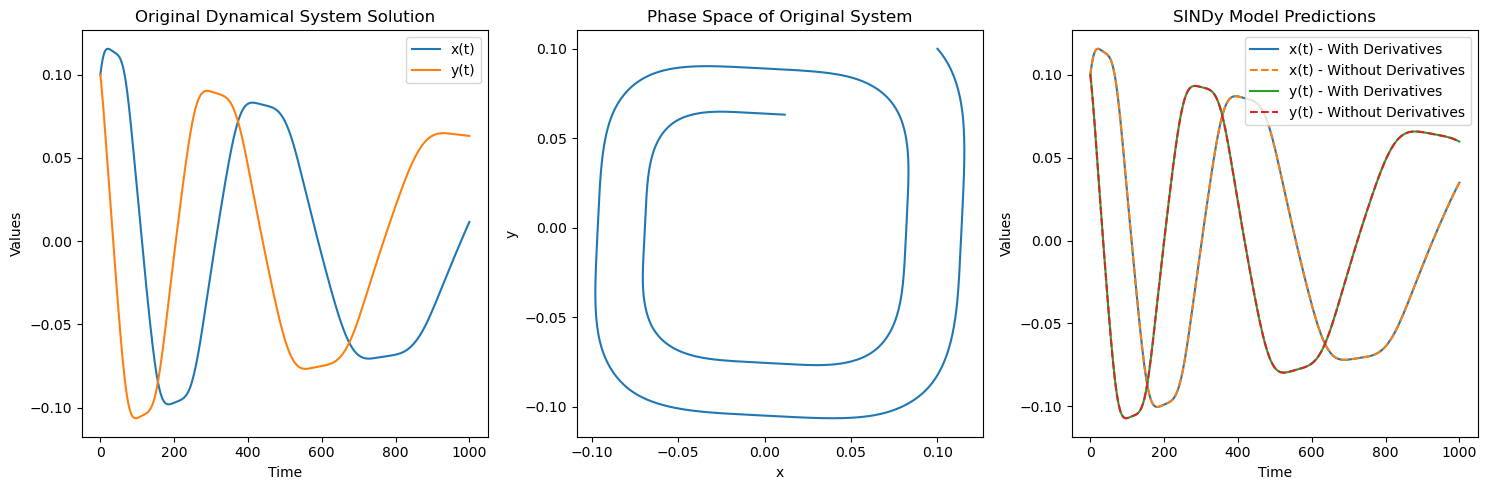

In [19]:
# Plot the original dynamical system solution (training data)
plt.figure(figsize=(15, 5))

# Plot x(t) and y(t) over time
plt.subplot(1, 3, 1)
plt.plot(t_data, x_data[:, 0], label='x(t)')
plt.plot(t_data, x_data[:, 1], label='y(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Original Dynamical System Solution')

# Phase space plot for the original system (x vs y)
plt.subplot(1, 3, 2)
plt.plot(x_data[:, 0], x_data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Phase Space of Original System')

# Compare the models fitted by SINDy with and without derivatives
# Use the SINDy models to predict over the same time span
sindy_x_with_derivatives = model_with_derivatives.simulate(x_data[0], t_data)
sindy_x_without_derivatives = model_with_x_only.simulate(x_data[0], t_data)

# Plot x(t) and y(t) predictions from SINDy model with derivatives
plt.subplot(1, 3, 3)
plt.plot(t_data, sindy_x_with_derivatives[:, 0], label='x(t) - With Derivatives')
plt.plot(t_data, sindy_x_without_derivatives[:, 0], label='x(t) - Without Derivatives', linestyle='--')
plt.plot(t_data, sindy_x_with_derivatives[:, 1], label='y(t) - With Derivatives')
plt.plot(t_data, sindy_x_without_derivatives[:, 1], label='y(t) - Without Derivatives', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('SINDy Model Predictions')

plt.tight_layout()
plt.show()

### Use SINDy to Learn the Dynamical System 

- 2 (d)

In [20]:
# Define the dynamical system (cubic damped SHO)
def cubic_damped_SHO(t, z):
    x, y = z
    dxdt = -0.1 * x**3 + 2 * y**3
    dydt = -2 * x**3 - 0.1 * y**3
    return [dxdt, dydt]

# Generate training data
dt = 0.0001  # time step
t_train = np.arange(0, 1000, dt)  # time points
t_train_span = (t_train[0], t_train[-1])  # time span for the ODE solver
x0_train = [0.1, 0.1]  # initial conditions
integrator_keywords = {'rtol': 1e-12, 'atol': 1e-12}  # integrator tolerance settings

# Solve the ODE to generate training data
x_train = solve_ivp(cubic_damped_SHO, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T

# Define a custom function library
def make_custom_functions():
    functions = [
        lambda x: 1,               # f1, constant term
        lambda x: x,               # f2(x), linear in x
        lambda y: y,               # f3(y), linear in y
        lambda x: x**2,            # f4(x^2), quadratic in x
        lambda y: y**2,            # f5(y^2), quadratic in y
        lambda x: x**4,            # f6(x^4), quartic in x
        lambda y: y**4,            # f7(y^4), quartic in y
        lambda x: x**5,            # f8(x^5), quintic in x
        lambda y: y**5,            # f9(y^5), quintic in y
        lambda x, y: x * y,        # f10(xy), interaction term
        lambda x, y: x**2 * y,     # f11(x^2 * y), mixed quadratic-cubic term
        lambda x, y: x * y**2,     # f12(x * y^2), mixed cubic-quadratic term
        lambda x, y: x**2 * y**2,  # f13(x^2 * y^2), mixed quadratic terms
        lambda x, y: x**4 * y,     # f14(x^4 * y), higher-order mixed terms
        lambda x, y: x * y**4,     # f15(x * y^4)
        lambda x, y: x**2 * y**3,  # f16(x^2 * y^3)
        lambda x, y: x**3 * y**2,  # f17(x^3 * y^2)
        lambda x, y: x**3 * y,     # f18(x^3 * y)
        lambda x, y: x * y**3      # f19(x * y^3)
    ]
    return functions

# Create the custom library
functions = make_custom_functions()
custom_lib = ps.CustomLibrary(
    library_functions=functions,
    interaction_only=True,  # consider only interaction terms
    include_bias=False  # exclude constant bias term
)

# Define the model and set the optimizer
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.0002),  # threshold for sparse regression
    feature_library=custom_lib
)

# Fit the model to the training data
model.fit(x_train, t=dt)

# Print the identified model
model.print()

(x0)' = 0.003 f1(x1) + 0.003 f2(x1) + 0.002 f3(x0) + -0.009 f3(x1) + 0.002 f4(x0) + -0.009 f4(x1) + -0.126 f5(x0) + 1.449 f5(x1) + -0.126 f6(x0) + 1.449 f6(x1) + -4.091 f7(x0) + 67.481 f7(x1) + -4.091 f8(x0) + 67.481 f8(x1) + 0.011 f9(x0,x1) + -0.816 f10(x0,x1) + 0.064 f11(x0,x1) + 0.165 f12(x0,x1) + 25.778 f13(x0,x1) + -7.480 f14(x0,x1) + 92.894 f15(x0,x1) + -12.132 f16(x0,x1) + -2.347 f18(x0,x1)
(x1)' = -0.004 f1(x0) + -0.004 f2(x0) + -0.017 f3(x0) + -0.017 f4(x0) + 1.965 f5(x0) + 0.048 f5(x1) + 1.965 f6(x0) + 0.048 f6(x1) + -58.003 f7(x0) + -1.559 f7(x1) + -58.003 f8(x0) + -1.559 f8(x1) + -0.151 f10(x0,x1) + 1.267 f11(x0,x1) + 2.526 f12(x0,x1) + 22.918 f13(x0,x1) + -53.447 f14(x0,x1) + 9.822 f15(x0,x1) + -122.207 f16(x0,x1) + -0.580 f17(x0,x1) + 0.109 f18(x0,x1)


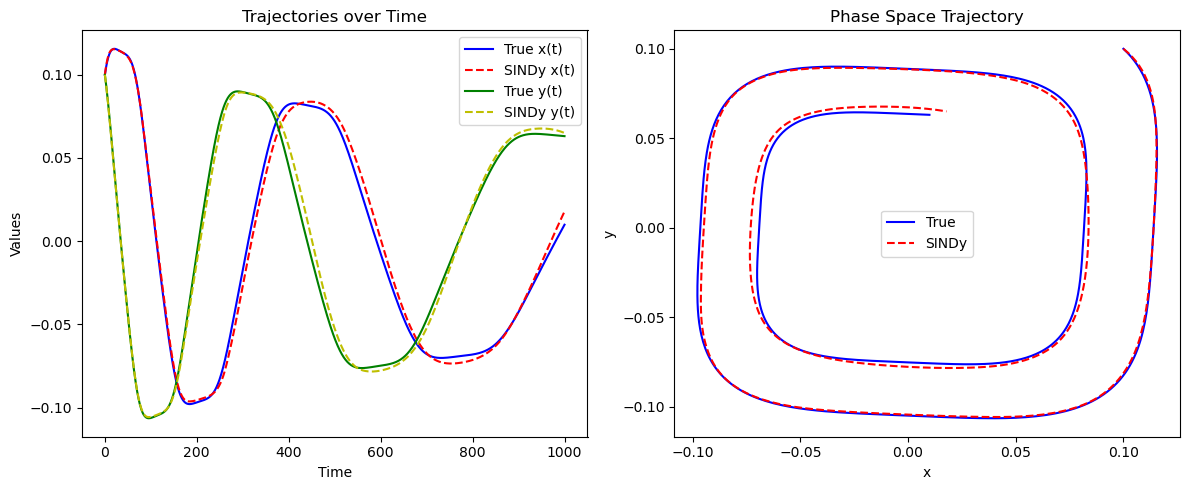

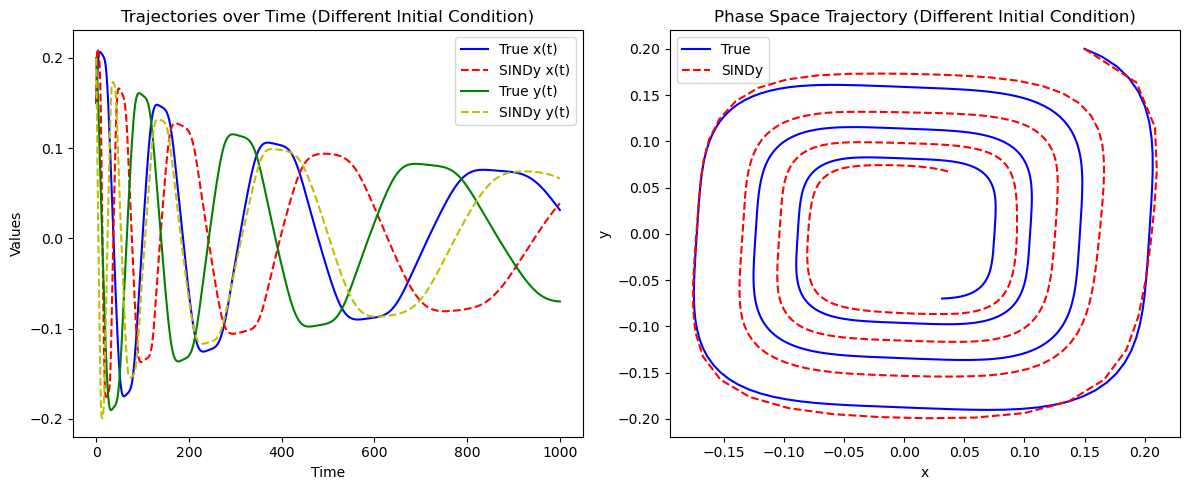

In [21]:
# Define a function to simulate the SINDy model and compare with true dynamics
def simulate_sindy_model(model, initial_state, t_span, t_eval):
    """Simulates the SINDy model for given initial conditions and time span."""
    def sindy_ode(t, z):
        return model.predict(z.reshape(1, -1)).flatten()
    
    # Solve the ODE using the SINDy model
    sindy_solution = solve_ivp(sindy_ode, t_span, initial_state, t_eval=t_eval)
    return sindy_solution

# Set up time points for evaluation and initial conditions
t_eval = np.linspace(0, 1000, 1000)  # time points for evaluation
initial_state = [0.1, 0.1]  # initial conditions for testing

# Solve the true system for comparison
true_solution = solve_ivp(cubic_damped_SHO, (t_eval[0], t_eval[-1]), initial_state, t_eval=t_eval, **integrator_keywords)

# Simulate the SINDy model with the same initial condition
sindy_solution = simulate_sindy_model(model, initial_state, (t_eval[0], t_eval[-1]), t_eval)

# Plot the trajectories over time
plt.figure(figsize=(12, 5))

# Plot x(t) and y(t) trajectories
plt.subplot(1, 2, 1)
plt.plot(t_eval, true_solution.y[0], 'b', label='True x(t)')
plt.plot(t_eval, sindy_solution.y[0], 'r--', label='SINDy x(t)')
plt.plot(t_eval, true_solution.y[1], 'g', label='True y(t)')
plt.plot(t_eval, sindy_solution.y[1], 'y--', label='SINDy y(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Trajectories over Time')

# Plot phase space trajectory (x vs y)
plt.subplot(1, 2, 2)
plt.plot(true_solution.y[0], true_solution.y[1], 'b', label='True')
plt.plot(sindy_solution.y[0], sindy_solution.y[1], 'r--', label='SINDy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Phase Space Trajectory')
plt.tight_layout()
plt.show()

# Try different initial conditions and compare results
new_initial_state = [0.15, 0.2]
true_solution_new_ic = solve_ivp(cubic_damped_SHO, (t_eval[0], t_eval[-1]), new_initial_state, t_eval=t_eval, **integrator_keywords)
sindy_solution_new_ic = simulate_sindy_model(model, new_initial_state, (t_eval[0], t_eval[-1]), t_eval)

# Plot for different initial conditions
plt.figure(figsize=(12, 5))

# Plot x(t) and y(t) trajectories with new initial condition
plt.subplot(1, 2, 1)
plt.plot(t_eval, true_solution_new_ic.y[0], 'b', label='True x(t)')
plt.plot(t_eval, sindy_solution_new_ic.y[0], 'r--', label='SINDy x(t)')
plt.plot(t_eval, true_solution_new_ic.y[1], 'g', label='True y(t)')
plt.plot(t_eval, sindy_solution_new_ic.y[1], 'y--', label='SINDy y(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Trajectories over Time (Different Initial Condition)')

# Plot phase space trajectory (x vs y) with new initial condition
plt.subplot(1, 2, 2)
plt.plot(true_solution_new_ic.y[0], true_solution_new_ic.y[1], 'b', label='True')
plt.plot(sindy_solution_new_ic.y[0], sindy_solution_new_ic.y[1], 'r--', label='SINDy')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Phase Space Trajectory (Different Initial Condition)')
plt.tight_layout()
plt.show()
